In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Libraries**

In [3]:
import pandas as pd
import numpy as np
import re
import string

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# **Download NLTK Resources**

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# **Load Dataset**

In [5]:
file_path = "/content/drive/MyDrive/Dataset/WELFake_Dataset.csv"
df = pd.read_csv(file_path)

df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


# **Basic Dataset Inspection**

In [6]:
print(df.shape)
print(df.columns)
print(df['label'].value_counts())

(72134, 4)
Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')
label
1    37106
0    35028
Name: count, dtype: int64


# **Handle Missing Values**

In [7]:
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')

# Combine title + text
df['content'] = df['title'] + " " + df['text']

# **Text Preprocessing Function**

In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation & numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)

    # Tokenize
    tokens = text.split()

    # Remove stopwords & lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(tokens)


# **Apply Preprocessing**

In [9]:
df['clean_text'] = df['content'].apply(preprocess_text)

df[['content', 'clean_text']].head()

,content,clean_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,law enforcement high alert following threat co...
1,Did they post their votes for Hillary already?,post vote hillary already
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,unbelievable obama’s attorney general say char...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",bobby jindal raised hindu us story christian c...
4,SATAN 2: Russia unvelis an image of its terrif...,satan russia unvelis image terrifying new ‘sup...


<Axes: xlabel='label'>

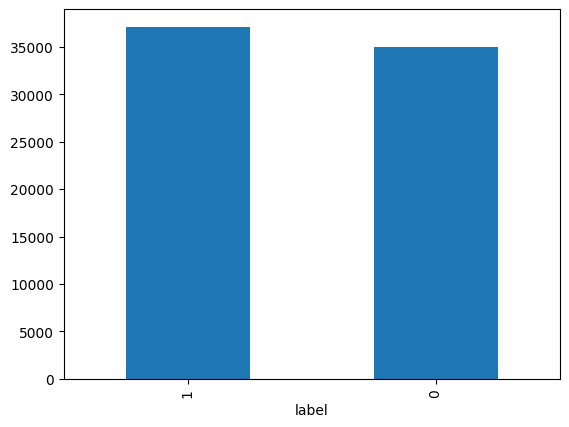

In [18]:
df['label'].value_counts().plot(kind='bar')

# **Train-Test Split**

In [10]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# **Feature Extraction (TF-IDF)**

In [11]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# **Rule-Based Fake News Classifier**

In [12]:
fake_keywords = [
    'breaking', 'shocking', 'unbelievable', 'exclusive',
    'secret', 'you wont believe', 'exposed', 'truth revealed'
]

def rule_based_classifier(text):
    for word in fake_keywords:
        if word in text:
            return 1  # fake
    return 0  # real

rule_predictions = X_test.apply(rule_based_classifier)

# **Rule-Based Evaluation**

In [13]:
print("Rule-Based Accuracy:", accuracy_score(y_test, rule_predictions))
print(classification_report(y_test, rule_predictions))

Rule-Based Accuracy: 0.5069661052193803
              precision    recall  f1-score   support

           0       0.49      0.74      0.59      7006
           1       0.54      0.29      0.38      7421

    accuracy                           0.51     14427
   macro avg       0.52      0.51      0.48     14427
weighted avg       0.52      0.51      0.48     14427



# **Machine Learning Model (Naive Bayes)**

In [14]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred = nb_model.predict(X_test_tfidf)
y_prob = nb_model.predict_proba(X_test_tfidf)[:,1]

# **ML Evaluation Metrics**

In [15]:
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)

Naive Bayes Accuracy: 0.8525681014763984
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      7006
           1       0.84      0.87      0.86      7421

    accuracy                           0.85     14427
   macro avg       0.85      0.85      0.85     14427
weighted avg       0.85      0.85      0.85     14427

ROC-AUC Score: 0.9291434146403013


# **Confusion Matrix Visualisation**

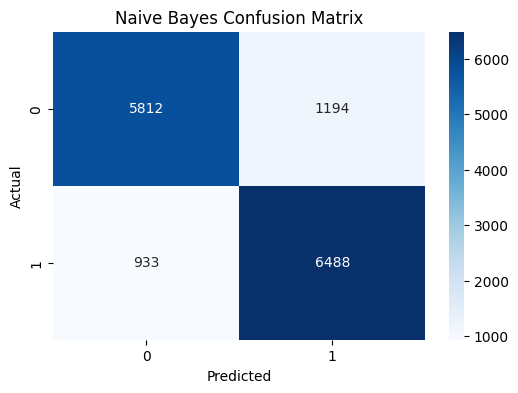

In [16]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Naive Bayes Confusion Matrix")
plt.show()

# **Top TF-IDF Features**

In [17]:
feature_names = np.array(tfidf.get_feature_names_out())
top_fake = np.argsort(nb_model.feature_log_prob_[1])[-20:]

print("Top words indicating FAKE news:")
for i in reversed(top_fake):
    print(feature_names[i])

Top words indicating FAKE news:
trump
clinton
hillary
video
people
obama
one
president
said
like
state
would
american
donald
time
election
donald trump
republican
woman
news
